In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

#from plotly import plotly
#import plotly.offline as offline
#import plotly.graph_objs as go
#offline.init_notebook_mode()
from collections import Counter

In [3]:
preprocessed_data = pd.read_csv('upsampled_data.csv')

In [6]:
preprocessed_data.head(2)


,Unnamed: 0,index,Unnamed: 0.1,teacher_prefix,project_grade_category,project_subject_subcategories,teacher_number_of_previously_posted_projects,project_is_approved,year_month,cleaned_subjects,ppd_essays,ppd_res_summary,price,quantity,essay_word_count,title_word_count,ppd_titles,school_state
0,0,0,41656,mrs,grades_6_8,Literature_Writing & Special_Needs,11,0,17-03,Literacy_Language & Special_Needs,remember given work independently seat teacher...,students need reading kits reading writing ski...,343.97,10,240,6,i do we do you do,il
1,1,1,21484,ms,grades_prek_2,Literature_Writing & Mathematics,0,0,16-12,Literacy_Language & Math_Science,words teacher would love hear students autism ...,students need l foundation skills learning set...,441.61,6,307,4,we can do it,fl


In [5]:
preprocessed_data.shape

(175416, 18)

# Splitting data into X & Y

In [7]:
y = preprocessed_data['project_is_approved'].values
x = preprocessed_data.drop(['project_is_approved'], axis=1)
x.head(1)

,Unnamed: 0,index,Unnamed: 0.1,teacher_prefix,project_grade_category,project_subject_subcategories,teacher_number_of_previously_posted_projects,year_month,cleaned_subjects,ppd_essays,ppd_res_summary,price,quantity,essay_word_count,title_word_count,ppd_titles,school_state
0,0,0,41656,mrs,grades_6_8,Literature_Writing & Special_Needs,11,17-03,Literacy_Language & Special_Needs,remember given work independently seat teacher...,students need reading kits reading writing ski...,343.97,10,240,6,i do we do you do,il


# Splitting data into Train & Test data (No need for sep. CV because we are doing N-fold Grid Search CV)

In [8]:
print(y)
print(type(y))
y.size

[0 0 0 ... 0 0 0]
<class 'numpy.ndarray'>


175416

In [9]:
from sklearn.model_selection import train_test_split
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.33, stratify=y)

print(y_tr.size)
print(y_te.size)
print(x_tr.shape)
print(x_te.shape)

117528
57888
(117528, 17)
(57888, 17)


In [11]:
unique_elements_tr, counts_elements_tr = np.unique(y_tr, return_counts=True)
unique_elements_te, counts_elements_te = np.unique(y_te, return_counts=True)

print(unique_elements_tr, counts_elements_tr)
print(unique_elements_te, counts_elements_te )

[0 1] [55415 62113]
[0 1] [27295 30593]


# Vectorization - Essay, Project_title, Project Summary

In [12]:
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4))
vectorizer.fit(x_tr['ppd_essays'].values)

# we use the fitted CountVectorizer to convert the text to vector
x_tr_essay_bow = vectorizer.transform(x_tr['ppd_essays'].values)
x_te_essay_bow = vectorizer.transform(x_te['ppd_essays'].values)

print("After vectorizations")
print(x_tr_essay_bow.shape, y_tr.shape)
print(x_te_essay_bow.shape, y_te.shape)

After vectorizations
(117528, 423912) (117528,)
(57888, 423912) (57888,)


In [13]:
vectorizer = CountVectorizer()
vectorizer.fit(x_tr['ppd_titles'].values)

x_tr_title_bow = vectorizer.transform(x_tr['ppd_titles'].values)
x_te_title_bow = vectorizer.transform(x_te['ppd_titles'].values)

print("After vectorizations")
print(x_tr_title_bow.shape, y_tr.shape)
print(x_te_title_bow.shape, y_te.shape)

After vectorizations
(117528, 14607) (117528,)
(57888, 14607) (57888,)


In [14]:
vectorizer = CountVectorizer()
vectorizer.fit(x_tr['ppd_res_summary'].values)

x_tr_res_summary_bow = vectorizer.transform(x_tr['ppd_res_summary'].values)
x_te_res_summary_bow = vectorizer.transform(x_te['ppd_res_summary'].values)

print("After vectorizations")
print(x_tr_res_summary_bow.shape, y_tr.shape)
print(x_te_res_summary_bow.shape, y_te.shape)

After vectorizations
(117528, 19315) (117528,)
(57888, 19315) (57888,)


In [15]:
vectorizer = CountVectorizer()
vectorizer.fit(x_tr['cleaned_subjects'].values)

x_tr_subjects_ohe = vectorizer.transform(x_tr['cleaned_subjects'].values)
x_te_subjects_ohe = vectorizer.transform(x_te['cleaned_subjects'].values)

print("After vectorizations")
print(x_tr_subjects_ohe.shape, y_tr.shape)
print(x_te_subjects_ohe.shape, y_te.shape)

After vectorizations
(117528, 9) (117528,)
(57888, 9) (57888,)


In [16]:
vectorizer = CountVectorizer()
vectorizer.fit(x_tr['project_subject_subcategories'].values)

x_tr_subject_subcat_ohe = vectorizer.transform(x_tr['project_subject_subcategories'].values)
x_te_subject_subcat_ohe = vectorizer.transform(x_te['project_subject_subcategories'].values)

print("After vectorizations")
print(x_tr_subject_subcat_ohe.shape, y_tr.shape)
print(x_te_subject_subcat_ohe.shape, y_te.shape)

After vectorizations
(117528, 30) (117528,)
(57888, 30) (57888,)


# Vectorization of Categorical features

In [17]:
vectorizer = CountVectorizer()
vectorizer.fit(x_tr['school_state'].values)

x_tr_state_ohe = vectorizer.transform(x_tr['school_state'].values)
x_te_state_ohe = vectorizer.transform(x_te['school_state'].values)

print("After vectorizations")
print(x_tr_state_ohe.shape, y_tr.shape)
print(x_te_state_ohe.shape, y_te.shape)

After vectorizations
(117528, 51) (117528,)
(57888, 51) (57888,)


In [18]:
vectorizer = CountVectorizer()
vectorizer.fit(x_tr['teacher_prefix'].values)

x_tr_tprefix_ohe = vectorizer.transform(x_tr['teacher_prefix'].values)
x_te_tprefix_ohe = vectorizer.transform(x_te['teacher_prefix'].values)

print("After vectorizations")
print(x_tr_tprefix_ohe.shape, y_tr.shape)
print(x_te_tprefix_ohe.shape, y_te.shape)

After vectorizations
(117528, 5) (117528,)
(57888, 5) (57888,)


In [19]:
vectorizer = CountVectorizer()
vectorizer.fit(x_tr['project_grade_category'].values)

x_tr_grade_ohe = vectorizer.transform(x_tr['project_grade_category'].values)
x_te_grade_ohe = vectorizer.transform(x_te['project_grade_category'].values)

print("After vectorizations")
print(x_tr_grade_ohe.shape, y_tr.shape)
print(x_te_grade_ohe.shape, y_te.shape)

After vectorizations
(117528, 4) (117528,)
(57888, 4) (57888,)


# Normalization - Price, Quantity, Previous Projects, Word_counts

In [20]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(x_tr['price'].values.reshape(-1,1))

x_tr_price_norm = normalizer.transform(x_tr['price'].values.reshape(-1,1))
x_te_price_norm = normalizer.transform(x_te['price'].values.reshape(-1,1))

print("After vectorizations")
print(x_tr_price_norm.shape, y_tr.shape)
print(x_te_price_norm.shape, y_te.shape)

After vectorizations
(117528, 1) (117528,)
(57888, 1) (57888,)


In [21]:
normalizer = Normalizer()
normalizer.fit(x_tr['quantity'].values.reshape(-1,1))

x_tr_quantity_norm = normalizer.transform(x_tr['quantity'].values.reshape(-1,1))
x_te_quantity_norm = normalizer.transform(x_te['quantity'].values.reshape(-1,1))

print("After vectorizations")
print(x_tr_quantity_norm.shape, y_tr.shape)
print(x_te_quantity_norm.shape, y_te.shape)

After vectorizations
(117528, 1) (117528,)
(57888, 1) (57888,)


In [22]:
normalizer = Normalizer()
normalizer.fit(x_tr['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

x_tr_prev_projects_norm = normalizer.transform(x_tr['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
x_te_prev_projects_norm = normalizer.transform(x_te['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(x_tr_prev_projects_norm.shape, y_tr.shape)
print(x_te_prev_projects_norm.shape, y_te.shape)

After vectorizations
(117528, 1) (117528,)
(57888, 1) (57888,)


In [23]:
normalizer = Normalizer()
normalizer.fit(x_tr['essay_word_count'].values.reshape(-1,1))

x_tr_essay_word_count_norm = normalizer.transform(x_tr['essay_word_count'].values.reshape(-1,1))
x_te_essay_word_count_norm = normalizer.transform(x_te['essay_word_count'].values.reshape(-1,1))

print("After vectorizations")
print(x_tr_essay_word_count_norm.shape, y_tr.shape)
print(x_te_essay_word_count_norm.shape, y_te.shape)

After vectorizations
(117528, 1) (117528,)
(57888, 1) (57888,)


In [24]:
normalizer = Normalizer()
normalizer.fit(x_tr['title_word_count'].values.reshape(-1,1))

x_tr_title_word_count_norm = normalizer.transform(x_tr['title_word_count'].values.reshape(-1,1))
x_te_title_word_count_norm = normalizer.transform(x_te['title_word_count'].values.reshape(-1,1))

print("After vectorizations")
print(x_tr_title_word_count_norm.shape, y_tr.shape)
print(x_te_title_word_count_norm.shape, y_te.shape)

After vectorizations
(117528, 1) (117528,)
(57888, 1) (57888,)


# Stacking of vectors

In [25]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((x_tr_essay_bow, x_tr_title_bow, x_tr_res_summary_bow, x_tr_subjects_ohe, x_tr_subject_subcat_ohe.shape, x_tr_state_ohe.shape, x_tr_tprefix_ohe.shape, x_tr_grade_ohe, x_tr_price_norm, x_tr_quantity_norm, x_tr_prev_projects_norm, x_tr_essay_word_count_norm, x_tr_title_word_count_norm)).tocsr()
X_te = hstack((x_te_essay_bow, x_te_title_bow, x_te_res_summary_bow, x_te_subjects_ohe, x_te_subject_subcat_ohe.shape, x_te_state_ohe.shape, x_te_tprefix_ohe.shape, x_te_grade_ohe, x_te_price_norm, x_te_quantity_norm, x_te_prev_projects_norm, x_te_essay_word_count_norm, x_te_title_word_count_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_tr.shape)
print(X_te.shape, y_te.shape)

Final Data matrix
(117528, 457938) (117528,)
(57888, 457938) (57888,)


In [26]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [27]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    print("50*=")
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print(50*"=")
print("Train confusion matrix")
print(confusion_matrix(y_tr, predict_with_best_t(y_tr_pred, best_t)))
print(50*"=")
print("Test confusion matrix")
print(confusion_matrix(y_te, predict_with_best_t(y_te_pred, best_t)))
print(50*"=")
print("Train F1 Score")
print(f1_score(y_tr, predict_with_best_t(y_tr_pred, best_t)))
print(50*"=")
print("Test F1 Score")
print(f1_score(y_te, predict_with_best_t(y_te_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.384082344473777 for threshold 0.792
Train confusion matrix
[[ 3207  1891]
 [11061 17341]]
Test confusion matrix
[[1534  977]
 [5543 8446]]
Train F1 Score
0.7280933786790948
Test F1 Score
0.7215103365795319


# Naive Bayes

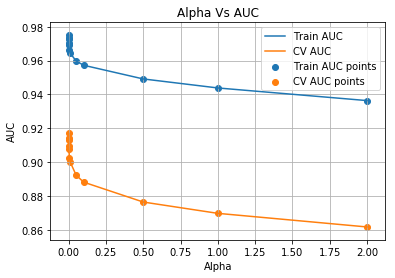

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.085825,0.048064,0.104249,0.039049,1e-05,{'alpha': 1e-05},0.915723,0.919388,0.915897,0.915596,...,0.916925,0.001519,1,0.975223,0.975204,0.974825,0.974545,0.975280,0.975015,0.000285
1,1.059377,0.097219,0.093255,0.011440,5e-05,{'alpha': 5e-05},0.913087,0.916745,0.913195,0.912915,...,0.914326,0.001582,2,0.973508,0.973532,0.973198,0.972900,0.973617,0.973351,0.000266
2,1.000740,0.040731,0.080374,0.000857,0.0001,{'alpha': 0.0001},0.911752,0.915655,0.912103,0.911252,...,0.913047,0.001710,3,0.972656,0.972699,0.972372,0.972028,0.972807,0.972512,0.000282
3,0.994918,0.056120,0.102830,0.021667,0.0005,{'alpha': 0.0005},0.908262,0.911966,0.908638,0.907785,...,0.909523,0.001639,4,0.970394,0.970387,0.970135,0.969793,0.970498,0.970241,0.000254
4,0.997011,0.042872,0.100865,0.022161,0.001,{'alpha': 0.001},0.906443,0.910060,0.906985,0.906097,...,0.907732,0.001557,5,0.969274,0.969312,0.968959,0.968681,0.969421,0.969129,0.000272


In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score

nb = MultinomialNB()
parameters = {'alpha':[0.00001,0.00005, 0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1,2]}
clf = GridSearchCV(nb, parameters, cv=5, scoring='roc_auc')
clf.fit(X_tr, y_tr)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
alp =  results['param_alpha']

plt.plot(alp, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alp, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alp, train_auc, label='Train AUC points')
plt.scatter(alp, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title("Alpha Vs AUC")
plt.grid()
plt.show()

results.head()

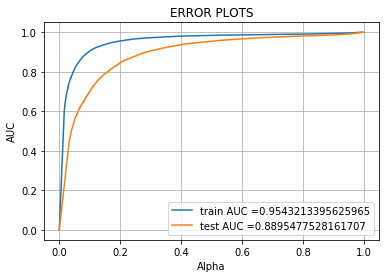

In [37]:
from sklearn.metrics import roc_curve, auc

nb = MultinomialNB(alpha=0.05)
nb.fit(X_tr, y_tr)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

#y_tr_pred = neigh.predict_proba(X_tr)   
#y_te_pred = neigh.predict_proba(X_te)

y_tr_pred = batch_predict(nb, X_tr)    
y_te_pred = batch_predict(nb, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_tr, y_tr_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_te, y_te_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [50]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    print("50*=")
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print(50*"=")
print("Train confusion matrix")
print(confusion_matrix(y_tr, predict_with_best_t(y_tr_pred, best_t)))
print(50*"=")
print("Test confusion matrix")
print(confusion_matrix(y_te, predict_with_best_t(y_te_pred, best_t)))
print(50*"=")
print("Train F1 Score")
print(f1_score(y_tr, predict_with_best_t(y_tr_pred, best_t)))
print(50*"=")
print("Test F1 Score")
print(f1_score(y_te, predict_with_best_t(y_te_pred, best_t)))
print(50*"=")
print("Train Accuracy Score")
print(accuracy_score(y_tr, predict_with_best_t(y_tr_pred, best_t)))
print(50*"=")
print("Test Accuracy Score")
print(accuracy_score(y_te, predict_with_best_t(y_te_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.8148887114099378 for threshold 0.728
50*=
Train confusion matrix
[[49573  5842]
 [ 5533 56580]]
Test confusion matrix
[[21962  5333]
 [ 4876 25717]]
Train F1 Score
0.9086602160035331
Test F1 Score
0.8343850883311974
Train Accuracy Score
0.9032145531277653
Test Accuracy Score
0.8236422056384743


# Vectorization of Essays, Project Titles, Resource Summary with Tfidf

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4))
vectorizer.fit(x_tr['ppd_essays'].values) 
x_tr_essay_tfidf = vectorizer.transform(x_tr['ppd_essays'].values)
x_te_essay_tfidf = vectorizer.transform(x_te['ppd_essays'].values)

print("After vectorizations")
print(x_tr_essay_tfidf.shape, y_tr.shape)
print(x_te_essay_tfidf.shape, y_te.shape)

After vectorizations
(117528, 423912) (117528,)
(57888, 423912) (57888,)


In [42]:
vectorizer = TfidfVectorizer()
vectorizer.fit(x_tr['ppd_titles'].values)

x_tr_title_tfidf = vectorizer.transform(x_tr['ppd_titles'].values)
x_te_title_tfidf = vectorizer.transform(x_te['ppd_titles'].values)

print("After vectorizations")
print(x_tr_title_tfidf.shape, y_tr.shape)
print(x_te_title_tfidf.shape, y_te.shape)

After vectorizations
(117528, 14607) (117528,)
(57888, 14607) (57888,)


In [43]:
vectorizer = TfidfVectorizer()
vectorizer.fit(x_tr['ppd_res_summary'].values)

x_tr_res_summary_tfidf = vectorizer.transform(x_tr['ppd_res_summary'].values)
x_te_res_summary_tfidf = vectorizer.transform(x_te['ppd_res_summary'].values)

print("After vectorizations")
print(x_tr_res_summary_tfidf.shape, y_tr.shape)
print(x_te_res_summary_tfidf.shape, y_te.shape)

After vectorizations
(117528, 19315) (117528,)
(57888, 19315) (57888,)


# Stacking of vectors

In [44]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((x_tr_essay_tfidf, x_tr_title_tfidf, x_tr_res_summary_tfidf, x_tr_subjects_ohe, x_tr_subject_subcat_ohe.shape, x_tr_state_ohe.shape, x_tr_tprefix_ohe.shape, x_tr_grade_ohe, x_tr_price_norm, x_tr_quantity_norm, x_tr_prev_projects_norm, x_tr_essay_word_count_norm, x_tr_title_word_count_norm)).tocsr()
X_te = hstack((x_te_essay_tfidf, x_te_title_tfidf, x_te_res_summary_tfidf, x_te_subjects_ohe, x_te_subject_subcat_ohe.shape, x_te_state_ohe.shape, x_te_tprefix_ohe.shape, x_te_grade_ohe, x_te_price_norm, x_te_quantity_norm, x_te_prev_projects_norm, x_te_essay_word_count_norm, x_te_title_word_count_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_tr.shape)
print(X_te.shape, y_te.shape)

Final Data matrix
(117528, 457938) (117528,)
(57888, 457938) (57888,)


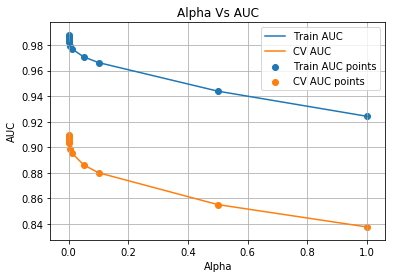

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.636962,0.049642,0.106051,0.012006,1e-05,{'alpha': 1e-05},0.908770,0.909546,0.909478,0.909264,0.000351,1,0.987789,0.987544,0.987769,0.987701,0.000111
1,0.696472,0.100731,0.103057,0.012676,5e-05,{'alpha': 5e-05},0.907331,0.908078,0.908200,0.907869,0.000384,2,0.986344,0.986108,0.986336,0.986263,0.000109
2,0.660567,0.048868,0.101395,0.006583,0.0001,{'alpha': 0.0001},0.906519,0.907245,0.907474,0.907080,0.000407,3,0.985605,0.985370,0.985596,0.985524,0.000109
3,0.646606,0.056219,0.086766,0.000812,0.0005,{'alpha': 0.0005},0.904012,0.904670,0.905214,0.904632,0.000492,4,0.983507,0.983280,0.983512,0.983433,0.000108
4,0.684836,0.070127,0.090758,0.005086,0.001,{'alpha': 0.001},0.902547,0.903176,0.903886,0.903203,0.000547,5,0.982394,0.982164,0.982403,0.982321,0.000110


In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score

nb = MultinomialNB()
parameters = {'alpha':[0.00001,0.00005, 0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1]}
clf = GridSearchCV(nb, parameters, cv=3, scoring='roc_auc')
clf.fit(X_tr, y_tr)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
alp =  results['param_alpha']

plt.plot(alp, train_auc, label='Train AUC')

plt.plot(alp, cv_auc, label='CV AUC')

plt.scatter(alp, train_auc, label='Train AUC points')
plt.scatter(alp, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title("Alpha Vs AUC")
plt.grid()
plt.show()

results.head()

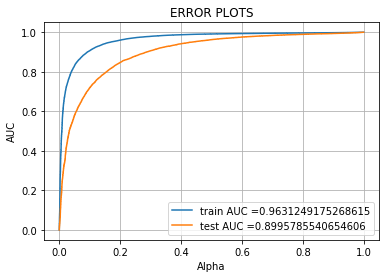

In [46]:
from sklearn.metrics import roc_curve, auc

nb = MultinomialNB(alpha=0.05)
nb.fit(X_tr, y_tr)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

#y_tr_pred = neigh.predict_proba(X_tr)   
#y_te_pred = neigh.predict_proba(X_te)

y_tr_pred = batch_predict(nb, X_tr)    
y_te_pred = batch_predict(nb, X_te)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_tr, y_tr_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_te, y_te_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print(50*"=")
print("Train confusion matrix")
print(confusion_matrix(y_tr, predict_with_best_t(y_tr_pred, best_t)))
print(50*"=")
print("Test confusion matrix")
print(confusion_matrix(y_te, predict_with_best_t(y_te_pred, best_t)))
print(50*"=")
print("Train F1 Score")
print(f1_score(y_tr, predict_with_best_t(y_tr_pred, best_t)))
print(50*"=")
print("Test F1 Score")
print(f1_score(y_te, predict_with_best_t(y_te_pred, best_t)))
print(50*"=")
print("Train Accuracy Score")
print(accuracy_score(y_tr, predict_with_best_t(y_tr_pred, best_t)))
print(50*"=")
print("Test Accuracy Score")
print(accuracy_score(y_te, predict_with_best_t(y_te_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.8173826893918353 for threshold 0.561
50*=
Train confusion matrix
[[50308  5107]
 [ 6189 55924]]
Test confusion matrix
[[22722  4573]
 [ 5639 24954]]
Train F1 Score
0.9082699928538945
Test F1 Score
0.8301397205588821
Train Accuracy Score
0.9038867333741747
Test Accuracy Score
0.8235903814262023
